#### This Notebook is for analyzing uncertainty of SpeCollate embeddings

In [1]:
import ast
import os
import pickle
import re
from collections import OrderedDict
from configparser import ConfigParser
from os.path import join

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.mixture import GaussianMixture
from scipy.special import iv, logsumexp

from spherecluster import VonMisesFisherMixture
from sklearn.neighbors import NearestNeighbors
from tqdm.notebook import tqdm

import sys

sys.path.append("../")
sys.path.append("../src")
from src.snapconfig import config

config.PARAM_PATH = "../config.ini"
import run_train as main
from src.snaptrain import dataset, trainmodel
from src.snaputils import simulatespectra as sim

/lclhome/mtari008/anaconda3/envs/deepsnap-sk-0.22/lib/python3.10/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)
/lclhome/mtari008/anaconda3/envs/deepsnap-sk-0.22/lib/python3.10/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
# Temporary config func. Original one in the project.
class config:
    """Define constants"""

    AAMass = OrderedDict(
        [
            ("A", 71.037114),
            ("C", 103.009185),
            ("D", 115.026943),
            ("E", 129.042593),
            ("F", 147.068414),
            ("G", 57.021464),
            ("H", 137.058912),
            ("I", 113.084064),
            ("K", 128.094963),
            ("L", 113.084064),
            ("M", 131.040485),
            ("N", 114.042927),
            ("P", 97.052764),
            ("Q", 128.058578),
            ("R", 156.101111),
            ("S", 87.032028),
            ("T", 101.047679),
            ("V", 99.068414),
            ("W", 186.079313),
            ("Y", 163.0633),
            ("p", 79.9663),
            ("o", 15.994915),
            ("h", 0.9840),
            ("c", 57.02146),
            ("a", 42.0106),
            ("r", -17.026549),
            ("y", 43.00581),
            ("d", -18.010565),
            ("t", 26.02),
        ]
    )

    aas = ["_PAD"] + list(AAMass.keys())
    aa2idx = {a: i for i, a in enumerate(aas)}

    ModMass = {
        "Oxidation": 15.994915,
        "CAM": 57.02146,
        "Carbamidomethyl": 57.02146,
        "ICAT_light": 227.12,
        "ICAT_heavy": 236.12,
        "AB_old_ICATd0": 442.20,
        "AB_old_ICATd8": 450.20,
        "Acetyl": 42.0106,
        "Deamidation": 0.9840,
        "Pyro-cmC": -17.026549,
        "Pyro-glu": -17.026549,
        "Pyro_glu": -18.010565,
        "Amide": -0.984016,
        "Phospho": 79.9663,
        "Methyl": 14.0157,
        "Carbamyl": 43.00581,
    }

    ModCHAR = OrderedDict(
        [
            ("15.99", "o"),
            ("57.02", "c"),
            ("0.98", "h"),
            ("42.01", "a"),
            ("-17.03", "r"),
            ("79.97", "p"),
            ("43.01", "y"),
            ("-18.01", "d"),
            ("26.02", "t"),
        ]
    )

    # ModCHAR = {"15.99": "o", "0.98": "h", "57.02": "c", "42.01": "a", "-17.03": "r", "79.97": "p"}
    Ignore = ["U", "X"]
    Mods = [
        {"mod_char": "p", "aas": ["S", "T", "Y"]}
        # {"mod_char": "o", "aas": ["nt", "M"]}
    ]
    H2O = 18.010564683
    NH3 = 17.031
    PROTON = 1.00727647

    DEFAULT_PARAM_PATH = os.path.join(os.getcwd(), "config.ini")
    PARAM_PATH = "../config.ini"
    l_config = None

    def get_config(section="input", key=None):
        """Read the configuration parameters and return a dictionary."""

        # If file path is given use it otherwise use default.
        file_path = config.PARAM_PATH if config.PARAM_PATH else config.DEFAULT_PARAM_PATH

        # Read config and convert each value to appropriate type.
        # Only for the first time.
        if not config.l_config:
            config.l_config = dict()
            config_ = ConfigParser()
            assert isinstance(file_path, str)
            config_.read(file_path)
            for section_ in config_.sections():
                config.l_config[section_] = dict()
                for key_ in config_[section_]:
                    try:
                        config.l_config[section_][key_] = ast.literal_eval(config_[section_][key_])
                    except (ValueError, SyntaxError):
                        config.l_config[section_][key_] = config_[section_][key_]

        if section and section in config.l_config:
            if key and key in config.l_config[section]:
                return config.l_config[section][key]
            return config.l_config[section]
        return config.l_config

In [3]:
print(config.get_config(section="search", key="charge"))
print(config.get_config(section="input", key="use_mods"))
print(config.get_config(section="ml", key="batch_size"))
print(config.get_config(section="input", key="num_species"))
print(config.get_config(section="search", key="num_mods"))
print(config.get_config(section="input", key="spec_size"))

5
False
1024
9
2
80000


In [4]:
def ppm(val, ppm_val):
    return (ppm_val / 1000000) * val

In [5]:
# adding useless comment
class Net(nn.Module):
    def __init__(
        self,
        vocab_size,
        output_size=512,
        embedding_dim=512,
        hidden_lstm_dim=1024,
        lstm_layers=2,
    ):
        super(Net, self).__init__()
        self.spec_size = config.get_config(section="input", key="spec_size")
        self.spec_size = 80000
        self.seq_len = config.get_config(section="ml", key="pep_seq_len")
        self.output_size = output_size
        self.lstm_layers = lstm_layers
        self.hidden_lstm_dim = hidden_lstm_dim
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size

        ################### Spectra branch ###################
        self.linear1_1 = nn.Linear(self.spec_size, 512)
        self.linear1_2 = nn.Linear(512, 256)

        ################### Peptide branch ###################
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim,
            self.hidden_lstm_dim,
            self.lstm_layers,
            # dropout=0.5,
            batch_first=True,
            bidirectional=True,
        )

        self.linear2_1 = nn.Linear(self.hidden_lstm_dim * 2, 512)  # 2048, 1024
        self.linear2_2 = nn.Linear(512, 256)
        do = config.get_config(section="ml", key="dropout")
        self.dropout1_1 = nn.Dropout(do)
        self.dropout2_1 = nn.Dropout(do)
        self.dropout2_2 = nn.Dropout(do)
        print("dropout: {}".format(do))

    def forward(self, data, data_type=None):
        assert not data_type or data_type == "specs" or data_type == "peps"
        res = []
        if not data_type or data_type == "specs":
            specs = data[0].squeeze()

            out = F.relu((self.linear1_1(specs.view(-1, self.spec_size))))
            out = self.dropout1_1(out)

            out_spec = F.relu(self.linear1_2(out))
            out_spec = F.normalize(out_spec)
            res.append(out_spec)

        if not data_type or data_type == "peps":
            for peps in data[1:3]:
                peps = peps.squeeze()
                embeds = self.embedding(peps)
                hidden = self.init_hidden(len(peps))
                hidden = tuple([e.data for e in hidden])
                lstm_out, _ = self.lstm(embeds, hidden)
                lstm_out = lstm_out[:, -1, :]
                out = lstm_out.contiguous().view(-1, self.hidden_lstm_dim * 2)
                out = self.dropout2_1(out)

                out = F.relu((self.linear2_1(out)))
                out = self.dropout2_2(out)

                out_pep = F.relu(self.linear2_2(out))
                out_pep = F.normalize(out_pep)
                res.append(out_pep)
        return res

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (
            weight.new(self.lstm_layers * 2, batch_size, self.hidden_lstm_dim).zero_(),
            weight.new(self.lstm_layers * 2, batch_size, self.hidden_lstm_dim).zero_(),
        )
        return hidden

    def one_hot_tensor(self, peps):
        batch_size = len(peps)
        src = torch.zeros((batch_size, self.seq_len), dtype=torch.float16, device="cuda")
        src[peps > 0] = 1.0
        one_hots = torch.zeros(
            (batch_size, self.seq_len, self.vocab_size),
            dtype=torch.float16,
            device="cuda",
        )
        one_hots.scatter_(
            2,
            peps.view(batch_size, self.seq_len, 1),
            src.view(batch_size, self.seq_len, 1),
        )
        one_hots.requires_grad = True
        return one_hots

    def name(self):
        return "Net"

In [6]:
rank = 0
world_size = 1
main.setup(rank, world_size)

In [7]:
model_name = "512-embed-2-lstm-SnapLoss2D-80k-nist-massive-no-mc-semi-r2r2r-22.pt"
snap_model = Net(vocab_size=30, embedding_dim=512, hidden_lstm_dim=512, lstm_layers=2).to(rank)
snap_model = nn.parallel.DistributedDataParallel(snap_model, device_ids=[rank])
snap_model.load_state_dict(torch.load("../models/{}".format(model_name))["model_state_dict"])
snap_model = snap_model.module
snap_model.eval()
print(snap_model)

dropout: 0.3
Net(
  (linear1_1): Linear(in_features=80000, out_features=512, bias=True)
  (linear1_2): Linear(in_features=512, out_features=256, bias=True)
  (embedding): Embedding(30, 512)
  (lstm): LSTM(512, 512, num_layers=2, batch_first=True, bidirectional=True)
  (linear2_1): Linear(in_features=1024, out_features=512, bias=True)
  (linear2_2): Linear(in_features=512, out_features=256, bias=True)
  (dropout1_1): Dropout(p=0.3, inplace=False)
  (dropout2_1): Dropout(p=0.3, inplace=False)
  (dropout2_2): Dropout(p=0.3, inplace=False)
)


In [9]:
# Training Data Embeddings
batch_size = config.get_config(section="ml", key="batch_size")
# in_tensor_dir = config.get_config(section='preprocess', key='in_tensor_dir') # for raptor
in_tensor_dir = "/lclhome/mtari008/data/deepsnap/nist_massiv_80k_no_ch_graymass-semi"  # for comet

(
    train_peps,
    train_specs,
    train_masses,
    test_peps,
    test_specs,
    test_masses,
) = main.read_split_listings(in_tensor_dir)

np_specs = []
spec_path = join(in_tensor_dir, "spectra")

# Wrap the outer loop with tqdm
for spec_file_list in tqdm(train_specs, desc="Outer Loop"):
    for spec_file in spec_file_list:
        np_spec = np.load(join(spec_path, spec_file))
        np_specs.append(np_spec)

/lclhome/mtari008/data/deepsnap/nist_massiv_80k_no_ch_graymass-semi
Reading train test split listings from pickles.


Outer Loop:   0%|          | 0/1498374 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [9]:
train_dataset = dataset.LabeledSpectra(in_tensor_dir, train_peps, train_specs)
test_dataset = dataset.LabeledSpectra(in_tensor_dir, test_peps, test_specs)

train_peps_strings, train_dpeps_strings = [], []
train_peps_masses, train_dpeps_masses = [], []
for train_pep in train_peps:
    pep_path = join(in_tensor_dir, "peptides", train_pep)
    with open(pep_path, "r") as f:
        pep = f.readlines()[0].strip()
        train_peps_masses.append(sim.get_pep_mass(pep))
        train_peps_strings.append(pep)
        dpep = train_dataset.get_decoy(pep)
        if dpep:
            train_dpeps_strings.append(dpep)
            train_dpeps_masses.append(sim.get_pep_mass(dpep))

vocab_size = train_dataset.vocab_size

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    num_workers=8,
    collate_fn=main.psm_collate,
    # batch_sampler=train_batch_sampler
    batch_size=batch_size,
    shuffle=False,
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    num_workers=8,
    collate_fn=main.psm_collate,
    # batch_sampler=test_batch_sampler,
    batch_size=batch_size,
    shuffle=False,
)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.cuda.set_device(rank)

q, p, d, train_spec_labels, train_spec_charges, train_spec_masses = (
    [],
    [],
    [],
    [],
    [],
    [],
)
print("Num batches: {}".format(len(train_loader)))
for idx, data in enumerate(train_loader):
    if idx % 1000 == 0:
        print("Batch: {}".format(idx))
    q_len = len(data[0])
    p_len = len(data[1])
    d_len = len(data[2])
    if p_len > d_len:
        seq_len = config.get_config(section="ml", key="pep_seq_len")  # + charge
        zero_pad = torch.zeros(p_len - d_len, seq_len, dtype=torch.long)
        data[2] = torch.cat((data[2], zero_pad))
    data[0] = data[0].to(rank)  # spectra
    data[1] = data[1].to(rank)  # peptides
    data[2] = data[2].to(rank)  # decoys
    Q, P, D = snap_model(data[:-1])
    Q = Q.detach().cpu().numpy()
    P = P.detach().cpu().numpy()
    D = D.detach().cpu().numpy()
    q.append(Q)
    p.append(P)
    d.append(D)
    l_spec_labels = np.repeat(np.arange(data[-1].size), data[-1])
    train_spec_labels.append(l_spec_labels)
    train_spec_charges.append(data[3])
    train_spec_masses.append(data[4])

q = np.concatenate(q)
p = np.concatenate(p)
d = np.concatenate(d)
train_spec_labels = np.concatenate(train_spec_labels)
train_spec_charges = np.concatenate(train_spec_charges)
train_spec_masses = np.concatenate(train_spec_masses)

NameError: name 'in_tensor_dir' is not defined

In [ ]:
# Sort q, train_dataset.np_specs, train_spec_charges by train_spec_masses
print("Sorting data by mass...")
zipped = zip(q, np_specs, train_spec_charges, train_spec_masses)
print(len(q), len(np_specs), len(train_spec_charges), len(train_spec_masses))
sorted_zipped = sorted(zipped, key=lambda x: x[-1])
q, np_specs, train_spec_charges, train_spec_masses = zip(*sorted_zipped)

print("Saving training data embeddings...")
np.save("training_data/q.npy", q)
np.save("training_data/p.npy", p)
np.save("training_data/d.npy", d)
np.save("training_data/spec_labels.npy", train_spec_labels)
np.save("training_data/charges.npy", train_spec_charges)
np.save("training_data/masses.npy", train_spec_masses)
pickle.dump(np_specs, open("training_data/np_specs.pkl", "wb"))
pickle.dump(train_peps_strings, open("training_data/peps.pkl", "wb"))
pickle.dump(train_dpeps_strings, open("training_data/dpeps.pkl", "wb"))
pickle.dump(train_peps_masses, open("training_data/pep_masses.pkl", "wb"))
pickle.dump(train_dpeps_masses, open("training_data/dpep_masses.pkl", "wb"))

Sorting data by mass...
3166015 3166015 3166015 3166015
Saving training data embeddings...


In [10]:
print(len(p), len(train_peps_masses), len(train_masses))

NameError: name 'p' is not defined

In [8]:
# load q, p, d, spec_labels, charges, peps, dpeps
q = np.load("training_data/q.npy")
p = np.load("training_data/p.npy")
d = np.load("training_data/d.npy")
# train_spec_labels = np.load("training_data/spec_labels.npy")
train_spec_charges = np.load("training_data/charges.npy")
train_spec_masses = np.load("training_data/masses.npy").flatten()
train_np_specs = pickle.load(open("training_data/np_specs.pkl", "rb"))
# train_peps_strings = pickle.load(open("training_data/peps.pkl", "rb"))
# train_dpeps_strings = pickle.load(open("training_data/dpeps.pkl", "rb"))
train_peps_masses = pickle.load(open("training_data/pep_masses.pkl", "rb"))
train_dpeps_masses = pickle.load(open("training_data/dpep_masses.pkl", "rb"))

In [45]:
import random

# batch_size  = config.get_config(section="ml", key="batch_size")
# in_tensor_dir_pt = "/lclhome/mtari008/data/deepsnap/proteome-tools/hcd"
# in_tensor_dir = "/disk/raptor-2/mtari008/data/deepsnap/train-ready/proteome-tools/"
in_tensor_dir_pt = "/lclhome/mtari008/data/deepsnap/mouse"

with open(join(in_tensor_dir_pt, "pep_spec.pkl"), "rb") as f:
    dir_listing = pickle.load(f)

# random.shuffle(dir_listing)

dir_listing = sorted(dir_listing, key=lambda x: float(re.search(r"(\d+)-(\d+.\d+).[pep]", x[0])[2]))
pre_mass = 2000
pre_mass_max = 6000
tol = 100
len_spec_list = 1
total_count = 10000000
min_mass = pre_mass - 1  # ppm(pre_mass, tol)
max_mass = pre_mass + 1  # ppm(pre_mass, tol)

l_pep_file_names = []
l_spec_file_names_lists = []
num_specs = []
spec_count = 0
pep_set = set()
for pep, spec_list in dir_listing:
    pep_mass = float(re.search(r"(\d+)-(\d+.\d+).[pep]", pep)[2])
    #     if len(spec_list) >= 3 and min_mass < pep_mass < max_mass:
    if len(spec_list) >= len_spec_list and pre_mass_max >= pep_mass >= pre_mass:
        # print(pep_mass)
        #         print(pep)
        #         print(spec_list)
        l_pep_file_names.append(pep)
        l_spec_file_names_lists.append(spec_list)
        num_specs.append(len(spec_list))
        spec_count += 1
        if spec_count >= total_count:
            break

assert len(l_pep_file_names) == len(l_spec_file_names_lists)
print(len(l_pep_file_names))

8366


In [46]:
def drop_columns_by_percentage(array, percentage):
    if percentage < 0 or percentage > 1:
        raise ValueError("Percentage should be between 0 and 1")

    if percentage == 0:
        return array

    num_columns_to_drop = int(array.shape[1] * percentage)
    random_indices = random.sample(range(array.shape[1]), num_columns_to_drop)
    column_mask = np.ones(array.shape[1], dtype=bool)
    column_mask[random_indices] = False
    return array[:, column_mask]


def get_dense_tensor_from_sparse_numpy(sparse_array, means, stds, spec_size, drop_percentage=0.0):
    sparse_array = drop_columns_by_percentage(sparse_array, drop_percentage)
    ind = torch.LongTensor(np.array([[0] * sparse_array.shape[1], sparse_array[0]]))
    val = torch.FloatTensor(sparse_array[1])
    dense_array = torch.sparse_coo_tensor(ind, val, torch.Size([1, spec_size])).to_dense()
    return (dense_array - means) / stds


def pad_left(arr, size):
    out = np.zeros(size)
    out[-len(arr) :] = arr
    return out


def get_pep(pep_file_name, seq_len):
    with open(pep_file_name, "r") as f:
        pep = f.readlines()[0].strip()[5:]

    pepl = [config.aa2idx[aa] for aa in pep]
    pepl = pad_left(pepl, seq_len)
    torch_pep = torch.tensor(pepl, dtype=torch.long)

    return torch_pep, pep

In [47]:
seq_len = config.get_config(section="ml", key="pep_seq_len")
pep_path = join(in_tensor_dir_pt, "peptides")
train_peps_strings = []
test_pep_strings = []

spec_path = join(in_tensor_dir_pt, "spectra")
spec_size = config.get_config(section="input", key="spec_size")

means = np.load(join(in_tensor_dir_pt, "means.npy"))
stds = np.load(join(in_tensor_dir_pt, "stds.npy"))
means = torch.from_numpy(means).float()
stds = torch.from_numpy(stds).float()

torch_spec_list, test_np_specs, test_spec_charge_list, test_spec_mass_list = (
    [],
    [],
    [],
    [],
)
# allowed_charges = {2, 3, 4}
allowed_charges = {2}
# percentages = [0.0, 0.05, 0.1, 0.15]
percentages = [0.0, 0.1, 0.2]
num_specs = []
keep = 2000
pep_count = 0
for spec_file_list, pep_file_name in zip(l_spec_file_names_lists, l_pep_file_names):
    (
        l_test_np_specs,
        l_torch_spec_list,
        l_test_spec_charge_list,
        l_test_spec_mass_list,
    ) = ([], [], [], [])
    pep_mass = float(re.search(r"(\d+)-(\d+.\d+).[pep]", pep_file_name)[2])
    pep_path = join(in_tensor_dir_pt, "peptides")
    pep_file_name = join(pep_path, pep_file_name)
    torch_pep, pep = get_pep(pep_file_name, seq_len)
    found_charges = set()
    spec_count = 0
    for spec_file in spec_file_list:
        file_parts = re.search(r"(\d+)\.(\d+)-(\d+)-(\d+.\d+)-(\d+)-(\d+).[pt|npy]", spec_file)
        spec_mass = float(file_parts[4])
        spec_charge = int(file_parts[5])
        # if spec_charge not in allowed_charges or spec_charge in found_charges:
        #     continue
        # found_charges.add(spec_charge)
        np_spec = np.load(join(spec_path, spec_file))
        for drop_percentage in percentages:
            spec_count += 1
            torch_spec = get_dense_tensor_from_sparse_numpy(
                np_spec, means, stds, spec_size, drop_percentage=drop_percentage
            )
            l_test_np_specs.append(np_spec)
            l_torch_spec_list.append(torch_spec)
            l_test_spec_charge_list.append(spec_charge)
            l_test_spec_mass_list.append(pep_mass)

    if spec_count == len(percentages) * len(allowed_charges):  # Uncomment to enable for variation metric
        # if spec_count > 0: # Uncomment for other metrics
        num_specs.append(spec_count)
        train_peps_strings.append(torch_pep)
        test_pep_strings.append(pep)
        (
            l_test_np_specs,
            l_torch_spec_list,
            l_test_spec_charge_list,
            l_test_spec_mass_list,
        ) = zip(
            *sorted(
                zip(
                    l_test_np_specs,
                    l_torch_spec_list,
                    l_test_spec_charge_list,
                    l_test_spec_mass_list,
                ),
                key=lambda x: x[2],
            )
        )

        test_np_specs.extend(l_test_np_specs)
        torch_spec_list.extend(l_torch_spec_list)
        test_spec_charge_list.extend(l_test_spec_charge_list)
        test_spec_mass_list.extend(l_test_spec_mass_list)
        pep_count += 1

    if pep_count >= keep:
        break

    # else:
    #     # pop the count values from torch_spec_list, spec_charge_list, spec_mass_list
    #     for i in range(count):
    #         torch_spec_list.pop()
    #         test_np_specs.pop()
    #         test_spec_charge_list.pop()
    #         test_spec_mass_list.pop()

    # torch_spec_charge_list = [self.charge2idx[charge] for charge in torch_spec_charge_list]
test_spec_charges = np.array(test_spec_charge_list)
test_spec_masses = np.array(test_spec_mass_list)
print(test_spec_charges.shape)
torch_specs = torch.cat(torch_spec_list, dim=0)
torch_peps = torch.stack(train_peps_strings, dim=0)
print(len(torch_peps))

(5910,)
1970


In [48]:
def spec_collate(batch):
    # specs = torch.stack([item for item in batch], 0)
    dummy_pep = np.zeros(config.get_config(section="ml", key="pep_seq_len"))
    dummy_pep = torch.from_numpy(dummy_pep).long().unsqueeze(0)
    return [batch, dummy_pep]


def pep_collate(batch):
    # peps = torch.stack([item for item in batch], 0)
    dummy_spec = np.zeros(config.get_config(section="input", key="spec_size"))
    dummy_spec = torch.from_numpy(dummy_spec).float().unsqueeze(0)
    dummy_pep = np.zeros((2, config.get_config(section="ml", key="pep_seq_len")))
    dummy_pep = torch.from_numpy(dummy_pep).long()  # .unsqueeze(0)
    # tqdm.write("{}".format(peps.shape))
    # tqdm.write("{}".format(dummy_pep.shape))
    return [dummy_spec, batch, dummy_pep]


def runModel(batch, s_model, in_type, device):
    with torch.no_grad():
        accurate_labels = 0
        all_labels = 0
        loss = 0
        out_out = torch.Tensor().cpu()
        batch[0], batch[1] = batch[0].to(device), batch[1].to(device)
        if in_type == "specs":
            out_ = s_model(batch, data_type=in_type)[0]
        elif in_type == "peps":
            batch[2] = batch[2].to(device)
            out_ = s_model(batch, data_type=in_type)[0]
        out_out = torch.cat((out_out, out_.to("cpu")), dim=0)
        # bar.update(batch_idx)
    return out_out

In [49]:
torch_specs_collated = spec_collate(torch_specs)
torch_peps_collated = pep_collate(torch_peps)
test_e_specs_ood = runModel(torch_specs_collated, snap_model, "specs", rank).detach().numpy()
test_e_peps_ood = runModel(torch_peps_collated, snap_model, "peps", rank).detach().numpy()
test_spec_charges_ood = np.array(test_spec_charge_list).astype(int)
num_specs_ood = np.array(num_specs)
test_spec_labels_ood = np.repeat(np.arange(num_specs_ood.size), num_specs)
test_np_specs_ood = test_np_specs
test_pep_strings_ood = test_pep_strings
test_spec_masses_ood = test_spec_masses

print(len(torch_peps))

1970


In [50]:
torch_specs_collated = spec_collate(torch_specs)
torch_peps_collated = pep_collate(torch_peps)
test_e_specs_id = runModel(torch_specs_collated, snap_model, "specs", rank).detach().numpy()
test_e_peps_id = runModel(torch_peps_collated, snap_model, "peps", rank).detach().numpy()
test_spec_charges_id = np.array(test_spec_charge_list).astype(int)
num_specs_id = np.array(num_specs)
test_spec_labels_id = np.repeat(np.arange(num_specs_id.size), num_specs)
test_np_specs_id = test_np_specs
test_pep_strings_id = test_pep_strings
test_spec_masses_id = test_spec_masses

In [51]:
# ood_path = "proteome_tools_data/cid/"
ood_path = "mouse-data-cid"

In [52]:
# test_e_specs, test_np_specs, test_spec_charges, test_spec_masses = zip(
#     *sorted(zip(test_e_specs, test_np_specs, test_spec_charges, test_spec_masses), key=lambda x: x[-1])
# )
np.save(join(ood_path, "e_specs.npy"), test_e_specs_ood)
pickle.dump(test_np_specs_ood, open(join(ood_path, "np_specs.pkl"), "wb"))
np.save(join(ood_path, "e_peps.npy"), test_e_peps_ood)
np.save(join(ood_path, "spec_charges.npy"), test_spec_charges_ood)
np.save(join(ood_path, "spec_masses.npy"), test_spec_masses_ood)
np.save(join(ood_path, "spec_labels.npy"), test_spec_labels_ood)
pickle.dump(test_pep_strings_ood, open(join(ood_path, "peps.pkl"), "wb"))

In [53]:
test_e_specs_ood = np.load(join(ood_path, "e_specs.npy"))
test_np_specs_ood = pickle.load(open(join(ood_path, "np_specs.pkl"), "rb"))
test_e_peps_ood = np.load(join(ood_path, "e_peps.npy"))
test_spec_charges_ood = np.load(join(ood_path, "spec_charges.npy"))
test_spec_masses_ood = np.load(join(ood_path, "spec_masses.npy"))
# test_spec_labels = np.load("proteome_tools_data/spec_labels.npy")
# test_pep_strings = pickle.load(open("proteome_tools_data/peps.pkl", "rb"))

In [21]:
save_append = "_rmv_peaks_augmnts"

In [22]:
test_e_specs_id = np.load(f"proteome_tools_data/hcd/e_specs{save_append}.npy")
test_np_specs_id = pickle.load(open(f"proteome_tools_data/hcd/np_specs{save_append}.pkl", "rb"))
test_e_peps_id = np.load(f"proteome_tools_data/hcd/e_peps{save_append}.npy")
test_spec_charges_id = np.load(f"proteome_tools_data/hcd/spec_charges{save_append}.npy")
test_spec_masses_id = np.load(f"proteome_tools_data/hcd/spec_masses{save_append}.npy")
# test_spec_labels = np.load("proteome_tools_data/spec_labels.npy")
# test_pep_strings = pickle.load(open("proteome_tools_data/peps.pkl", "rb"))

In [24]:
print(len(test_e_specs_id))

6000


In [23]:
def normalize_values(values):
    min_val, max_val = min(values), max(values)
    vals = np.array(values)
    normalized_values = (vals - min_val) / (max_val - min_val)
    print(min_val, max_val)
    print(normalized_values)
    return normalized_values

In [25]:
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from scipy.special import kl_div
from scipy.spatial.distance import jaccard


def compute_similarity_metrics(arr1, arr2):
    # Checking if both arrays have the same length
    if len(arr1) != len(arr2):
        raise ValueError("Both arrays must have the same length")

    # Reshaping to row vectors for compatibility with cosine_similarity
    arr1_2d, arr2_2d = np.array(arr1).reshape(1, -1), np.array(arr2).reshape(1, -1)

    # Flattening arrays for compatibility with pearsonr and spearmanr
    arr1_1d, arr2_1d = arr1_2d.flatten(), arr2_2d.flatten()

    # Pearson Correlation
    pearson_corr, _ = stats.pearsonr(arr1_1d, arr2_1d)

    # Spearman Correlation
    spearman_corr, _ = stats.spearmanr(arr1_1d, arr2_1d)

    # Mean Squared Error
    mse = mean_squared_error(arr1_1d, arr2_1d)

    # Root Mean Squared Error
    rmse = np.sqrt(mse)

    # Cosine Similarity
    cosine_sim = cosine_similarity(arr1_2d, arr2_2d)[0][0]

    # KL Divergence
    kl_divergence = kl_div(arr1_1d, arr2_1d).sum()

    # Jaccard Similarity
    jaccard_sim = 1 - jaccard(arr1_1d, arr2_1d)

    return {
        "pearson_corr": pearson_corr,
        "spearman_corr": spearman_corr,
        "mse": mse,
        "rmse": rmse,
        "cosine_sim": cosine_sim,
        "kl_divergence": kl_divergence,
        "jaccard_sim": jaccard_sim,
    }

In [26]:
# k = len(percentages) * len(allowed_charges)
k = 1
print(k)

1


In [27]:
def snap_score(e_specs, e_peps, k):
    # Check if len(e_specs) = k * len(e_peps)
    if len(e_specs) != k * len(e_peps):
        raise ValueError("len(e_specs) must be equal to k * len(e_peps)")

    # Reshape e_peps to match the shape of e_specs for broadcasting
    e_peps_rep = np.repeat(e_peps, k, axis=0)

    # Calculate squared L2 distance between e_specs and e_peps
    sq_dist = np.sum((e_specs - e_peps_rep) ** 2, axis=1)

    # Avoid division by zero
    sq_dist = np.where(sq_dist == 0, 1e-10, sq_dist)

    # Calculate SNAP score
    snap_scores = 1 / sq_dist

    return snap_scores


import bisect

from torch import le


def snap_score_2(e_specs, e_peps, spec_masses, pep_masses, mass_tol, k):
    # Check if len(e_specs) = k * len(e_peps)
    if len(e_specs) != k * len(e_peps):
        raise ValueError("len(e_specs) must be equal to k * len(e_peps)")

    # Reshape e_peps to match the shape of e_specs for broadcasting
    e_peps_rep = np.repeat(e_peps, k, axis=0)

    # Calculate squared L2 distance between e_specs and e_peps
    sq_dist = np.sum((e_specs - e_peps_rep) ** 2, axis=1)

    # Avoid division by zero
    sq_dist = np.where(sq_dist == 0, 1e-10, sq_dist)

    # Calculate SNAP score
    snap_scores = 1 / sq_dist

    # Sorting pep_masses and e_peps according to pep_masses
    sort_indices = np.argsort(pep_masses)
    pep_masses_sorted = pep_masses[sort_indices]
    e_peps_sorted = e_peps[sort_indices]

    snap_scores_max = []  # To store the highest snap scores within mass_tol range
    max_score_pep_ids = []  # To store the pep_ids corresponding to the highest snap scores

    for i in range(len(spec_masses)):
        # Binary search to find the range of peptides within mass_tol range
        lower_index = bisect.bisect_left(pep_masses_sorted, spec_masses[i] - mass_tol)
        upper_index = bisect.bisect_right(pep_masses_sorted, spec_masses[i] + mass_tol)

        # Compute squared L2 distance for peptides within mass_tol range
        sq_dist = np.sum((e_specs[i] - e_peps_sorted[lower_index:upper_index]) ** 2, axis=1)

        # Avoid division by zero
        sq_dist = np.where(sq_dist == 0, 1e-10, sq_dist)

        # Calculate SNAP scores for peptides within mass_tol range
        snap_scores_range = 1 / sq_dist

        # Find the highest SNAP score
        max_index = np.argmax(snap_scores_range)
        max_score_pep_ids.append(lower_index + max_index)
        snap_scores_max.append(snap_scores_range[max_index])

    # True if max_score_pep_ids values are the same as index
    is_correct = np.array(max_score_pep_ids) == np.repeat(np.arange(len(e_peps)), k)  # Labels

    return snap_scores, snap_scores_max, is_correct


from bisect import bisect_left, bisect_right


def snap_score_3(e_specs, e_peps, spec_masses, pep_masses, mass_tol):
    # Check if len(e_specs) and len(spec_masses) are the same, similarly for e_peps and pep_masses
    if len(e_specs) != len(spec_masses) or len(e_peps) != len(pep_masses):
        raise ValueError("Input arrays should have the same length")

    # Initialize an array to hold the snap scores
    snap_scores_max = np.zeros(len(e_specs))
    print(len(e_specs))
    print(len(e_peps))

    unmatched = 0

    # Compute the snap scores for each spectrum
    for i, (e_spec, spec_mass) in enumerate(zip(e_specs, spec_masses)):
        # Determine the lower and upper bounds for the mass tolerance
        lower_bound = spec_mass - mass_tol
        upper_bound = spec_mass + mass_tol

        # Find the indices of peptides within the mass tolerance range
        start_index = bisect_left(pep_masses, lower_bound)
        end_index = bisect_right(pep_masses, upper_bound)

        # Get the peptides within the mass tolerance range
        e_peps_in_range = e_peps[start_index:end_index]

        # Calculate squared L2 distances
        sq_dists = np.sum((e_spec - e_peps_in_range) ** 2, axis=1)

        # Avoid division by zero
        sq_dists = np.where(sq_dists == 0, 1e-10, sq_dists)
        if len(sq_dists) == 0:
            # print('empty')
            # print(i)
            # print(spec_mass)
            # print(lower_bound)
            # print(len(e_peps_in_range))
            # print(start_index)
            # print(end_index)
            # print(pep_masses[0])
            # print(pep_masses[-1])
            unmatched += 1
            snap_scores_max[i] = 0
        else:
            # Calculate and store the maximum SNAP score
            snap_scores_max[i] = np.max(1.0 / sq_dists)

    print("Unmatched: {} / {}".format(unmatched, len(e_specs)))

    return snap_scores_max

In [28]:
k = 1

In [54]:
test_snap_scores_id = snap_score(test_e_specs_id[0::k], test_e_peps_id, k=3)

test_snap_scores_3_id = snap_score_3(test_e_specs_id[0::k], p, test_spec_masses_id[0::k], train_peps_masses, 100)

test_snap_scores_2_id, test_snap_scores_max, test_is_correct = snap_score_2(
    test_e_specs_id[::k], test_e_peps_id, test_spec_masses_id[::k], test_spec_masses_id[::3], 1, k=3
)
# test_snap_scores = normalize_values(test_snap_scores)

5910
1498374
Unmatched: 0 / 5910


In [55]:
p_1 = sum(test_is_correct) / len(test_is_correct)
print(p_1)

0.5049069373942471


In [56]:
test_snap_scores_ood = snap_score(test_e_specs_ood[0::k], test_e_peps_ood, k=3)

test_snap_scores_3_ood = snap_score_3(test_e_specs_ood[0::k], p, test_spec_masses_ood[0::k], train_peps_masses, 100)

test_snap_scores_2_ood, test_snap_scores_max, test_is_correct = snap_score_2(
    test_e_specs_ood[::k], test_e_peps_ood, test_spec_masses_ood[::k], test_spec_masses_ood[::3], 100, k=3
)
# test_snap_scores = normalize_values(test_snap_scores)

5910
1498374


Unmatched: 0 / 5910


In [44]:
p_1 = sum(test_is_correct) / len(test_is_correct)
print(p_1)

0.08138481058546311


In [ ]:
in_dist_perf = [94.1, 93.8, 94.5]
out_of_dist_perf = [1.3, 3.3, 8.1]

In [28]:
def sum_of_variances(specs, k, keepdims=False):
    # Check if the number of vectors is divisible by k
    if len(specs) % k != 0:
        raise ValueError("The number of vectors must be divisible by k")

    # Calculate the number of chunks
    num_chunks = len(specs) // k

    # Create a new array of the right size, with each element initialized to zero
    sum_of_variances = np.zeros(num_chunks)

    # Use numpy's advanced indexing to create an array of shape (num_chunks, k, m)
    chunks = specs.reshape(num_chunks, k, -1)

    # Calculate the variance along the second axis (the k vectors)
    # then sum along the last axis (the m dimensions)
    sum_of_variances = (
        np.var(chunks, axis=1).sum(axis=-1) if not keepdims else np.var(chunks, axis=1).sum(axis=-1).repeat(k)
    )

    return sum_of_variances

In [42]:
test_e_specs_id = np.array(test_e_specs_id)
traces_id = sum_of_variances(test_e_specs_id, k=3, keepdims=True)
print(traces_id.shape)

(6000,)


In [43]:
test_e_specs_ood = np.array(test_e_specs_ood)
traces_ood = sum_of_variances(test_e_specs_ood, k=3, keepdims=True)
print(traces_ood.shape)

(6000,)


In [98]:
normalized_traces = normalize_values(traces)
print(max(normalized_traces), min(normalized_traces))

0.052476246 0.35775915
[0.5378537 0.5378537 0.5378537 ... 0.4281994 0.4281994 0.4281994]
1.0 0.0


In [99]:
def plot_distribution(
    data,
    baseline_value=0.64,
    baseline_color="red",
    bins=None,
    title="Distribution of Floating Point Numbers",
    xlabel="Value",
    ylabel="Frequency",
):
    # Plot the histogram
    n, bin_edges, patches = plt.hist(data, bins=bins, alpha=0.75)

    # Set the baseline height to the maximum height of the histogram
    baseline_height = max(n)

    # Add the baseline bar
    plt.bar(
        baseline_value,
        baseline_height,
        width=np.diff(bin_edges)[0],
        color=baseline_color,
        align="center",
    )

    # Set the x-axis limits to include the baseline value
    # plt.xlim(min(data + [baseline_value]), max(data + [baseline_value + 0.1]))

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

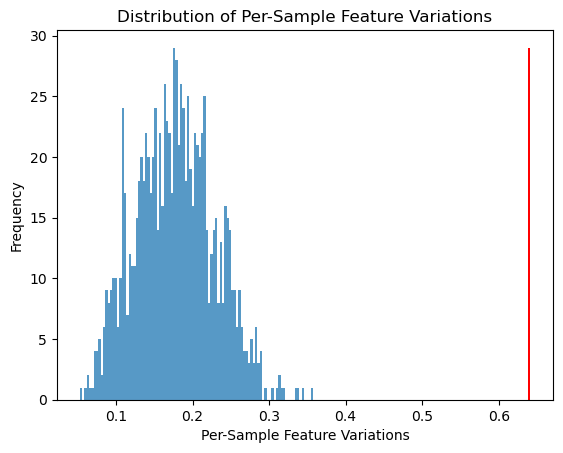

In [91]:
plot_distribution(
    traces,
    bins=100,
    title="Distribution of Per-Sample Feature Variations",
    xlabel="Per-Sample Feature Variations",
    ylabel="Frequency",
)

0.6056615 5.575473
[0.102892   0.18656453 0.1873476  ... 0.29123893 0.11148811 0.34197733]


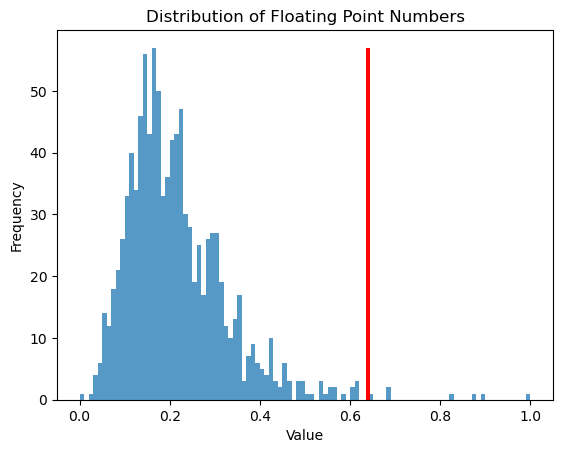

In [67]:
plot_distribution(normalize_values(test_snap_scores), bins=100)

In [92]:
snap_vs_trace = compute_similarity_metrics(normalize_values(test_snap_scores), normalize_values(1 / traces))

0.6056615 5.575473
[0.102892   0.18656453 0.1873476  ... 0.29123893 0.11148811 0.34197733]
2.7951765 19.056242
[0.11192725 0.12351498 0.14588192 ... 0.30210158 0.12270377 0.16378954]


In [93]:
print(snap_vs_trace)

{'pearson_corr': 0.5622835900527726, 'spearman_corr': 0.6197663305983908, 'mse': 0.01361604, 'rmse': 0.11668779, 'cosine_sim': 0.8875643, 'kl_divergence': 27.742065, 'jaccard_sim': 0.0}


In [73]:
def fit_gmm_and_estimate_density(data, n_components=3):
    # Fit a Gaussian Mixture Model to the data
    gmm = GaussianMixture(n_components=n_components)
    gmm.fit(data)

    # Estimate the density around each vector in the data
    log_prob_density = gmm.score_samples(data)

    return log_prob_density


prob_density = fit_gmm_and_estimate_density(e_peps, n_components=20)
print(len(prob_density), len(e_peps))
print(prob_density)
print(max(prob_density))

NameError: name 'e_peps' is not defined

In [25]:
def fit_vmf_and_estimate_density(data, n_clusters=3, max_iter=100, tol=1e-3):
    # Fit a von Mises-Fisher Mixture Model to the data
    vmf = VonMisesFisherMixture(n_clusters=n_clusters, max_iter=max_iter, tol=tol)
    vmf.fit(data)

    # Estimate the density around each vector in the data
    # density_estimates = vmf.predict_proba(data)
    # density_estimates = vmf.score(data)
    density_estimates = vmf.log_likelihood(data)

    return density_estimates


def fit_vmf_and_estimate_density_1(data, n_clusters=3, max_iter=100, tol=1e-3):
    m = data.shape[1]

    # Fit a von Mises-Fisher Mixture Model to the data
    vmf = VonMisesFisherMixture(n_clusters=n_clusters, max_iter=max_iter, tol=tol)
    vmf.fit(data)

    # Compute the log of the density estimate for each data point
    log_exp_terms = np.dot(data, vmf.cluster_centers_.T) * vmf.concentrations_
    log_const_terms = (np.log(vmf.concentrations_) * ((m - 1) / 2)) - (
        np.log(2 * np.pi) * (m / 2) + np.log(iv((m - 1) / 2, vmf.concentrations_))
    )
    log_density_estimate = logsumexp(log_const_terms + log_exp_terms, axis=1, b=vmf.weights_)

    # Normalize the log density estimates and convert back to the density estimate
    max_log_density_estimate = np.max(log_density_estimate)
    shifted_log_density_estimate = log_density_estimate - max_log_density_estimate
    sum_exp_shifted_log_density_estimate = np.sum(np.exp(shifted_log_density_estimate))
    normalized_log_density_estimate = shifted_log_density_estimate - np.log(sum_exp_shifted_log_density_estimate)
    density_estimate = np.exp(normalized_log_density_estimate)

    return log_density_estimate


def fit_vmf_and_estimate_density_2(data, p, n_clusters=3, max_iter=100, tol=1e-3):
    m = p.shape[1]

    # Fit a von Mises-Fisher Mixture Model to the training data p
    vmf = VonMisesFisherMixture(n_clusters=n_clusters, max_iter=max_iter, tol=tol)
    vmf.fit(
        p,
    )

    # Compute the log of the density estimate for each data point
    log_exp_terms = np.dot(data, vmf.cluster_centers_.T) * vmf.concentrations_
    log_const_terms = (np.log(vmf.concentrations_) * ((m - 1) / 2)) - (
        np.log(2 * np.pi) * (m / 2) + np.log(iv((m - 1) / 2, vmf.concentrations_))
    )
    log_density_estimate = logsumexp(log_const_terms + log_exp_terms, axis=1, b=vmf.weights_)

    # Normalize the log density estimates and convert back to the density estimate
    max_log_density_estimate = np.max(log_density_estimate)
    shifted_log_density_estimate = log_density_estimate - max_log_density_estimate
    sum_exp_shifted_log_density_estimate = np.sum(np.exp(shifted_log_density_estimate))
    normalized_log_density_estimate = shifted_log_density_estimate - np.log(sum_exp_shifted_log_density_estimate)
    density_estimate = np.exp(normalized_log_density_estimate)

    return log_density_estimate


def normalize_values(values):
    min_val, max_val = min(values), max(values)
    vals = np.array(values)
    normalized_values = (vals - min_val) / (max_val - min_val)
    print(min_val, max_val)
    print(normalized_values)
    return normalized_values

In [26]:
def plot_density_estimates(
    density_estimates,
    title="Density Estimates",
    xlabel="Vector Index",
    ylabel="Density",
):
    n_vectors = len(density_estimates)
    vector_indices = np.arange(n_vectors)

    # Create a bar plot of the density estimates
    plt.bar(vector_indices, density_estimates)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(vector_indices)
    plt.show()

In [27]:
def plot_density_distribution(
    density_estimates,
    bins=None,
    title="Density Distribution",
    xlabel="Density",
    ylabel="Frequency",
):
    # Create a histogram of the density estimates
    plt.hist(density_estimates, bins=bins, alpha=0.75)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.xlim(min(density_estimates), max(density_estimates))
    plt.ylabel(ylabel)
    plt.show()

In [34]:
density_estimates_peps = fit_vmf_and_estimate_density_1(test_e_peps, n_clusters=20)
print(density_estimates_peps)
print(min(density_estimates_peps), max(density_estimates_peps))

[404.4494762  408.16448506 429.47564574 ... 420.60978929 434.07934335
 401.53300264]
360.8988238923589 454.1438896300629


In [61]:
density_estimates_peps = normalize_values(density_estimates_peps)

NameError: name 'density_estimates_peps' is not defined

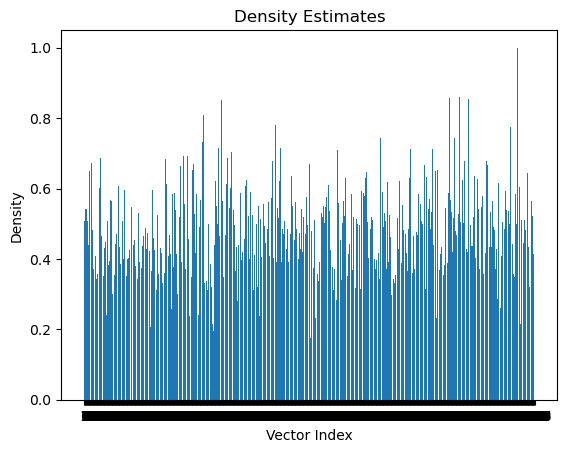

In [36]:
plot_density_estimates(density_estimates_peps)

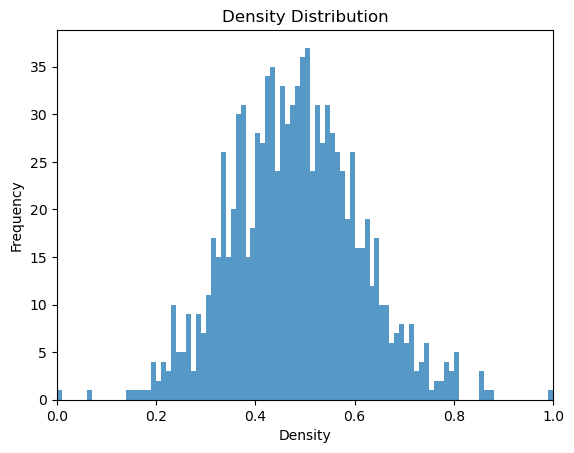

In [37]:
plot_density_distribution(density_estimates_peps, bins=100)

In [31]:
# prob_density_specs = fit_vmf_and_estimate_density_2(test_e_specs[::k], p, n_clusters=3)
prob_density_specs_ood = np.load("outputs/prob_density_specs_ood.npy")[0::k]

In [32]:
prob_density_specs_id = np.load("outputs/prob_density_specs_rmv_peaks_augmnts.npy")[0::k]

In [102]:
density = normalize_values(prob_density_specs)

369.0130058659732 412.31122076473497
[0.56908083 0.41769484 0.35153105 ... 0.4938188  0.71863613 0.58364761]


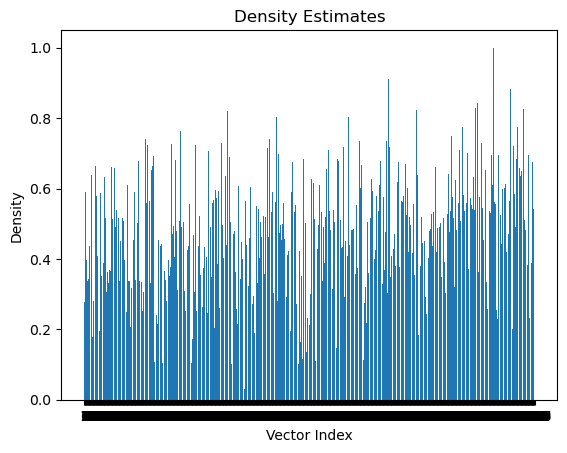

In [72]:
plot_density_estimates(density)

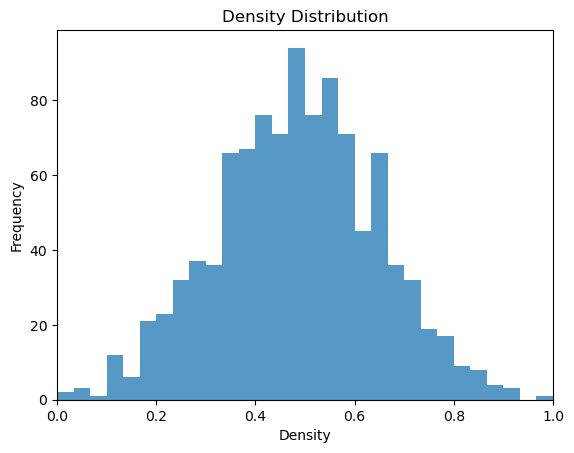

In [73]:
plot_density_distribution(density, bins=30)

In [103]:
snap_vs_density = compute_similarity_metrics(test_snap_scores, prob_density_specs)
print(snap_vs_density)

{'pearson_corr': -0.26689865847779426, 'spearman_corr': -0.2812029648296226, 'mse': 153312.12650801442, 'rmse': 391.55092453985395, 'cosine_sim': 0.9530871525339947, 'kl_divergence': 1167480.5922175765, 'jaccard_sim': 0.0}


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1.2866754531860352 5.30270528793335
[0.09456872 0.07425051 0.14174268 ... 0.25362087 0.20645542 0.415236  ]
369.0130058659732 412.31122076473497
[0.56908083 0.41769484 0.35153105 ... 0.4938188  0.71863613 0.58364761]


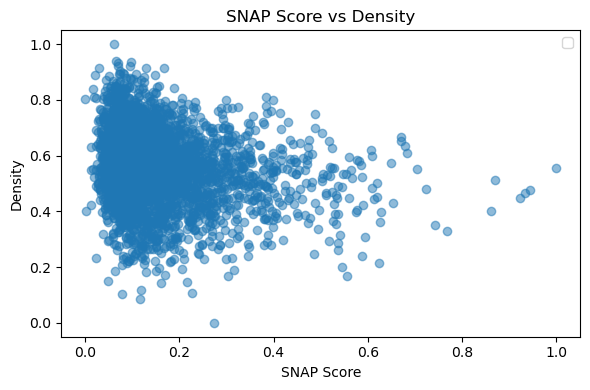

In [35]:
import matplotlib.pyplot as plt

# Assuming ref_scores, score1, score2, score3 are your score arrays
plt.figure(figsize=(6, 4))

# plt.subplot(1, 2, 1)
plt.scatter(
    normalize_values(test_snap_scores_3),
    normalize_values(prob_density_specs),
    alpha=0.5,
)
plt.xlabel("SNAP Score")
plt.ylabel("Density")
plt.title("SNAP Score vs Density")
plt.legend()

# plt.subplot(1, 2, 2)
# plt.scatter(normalize_values(test_snap_scores), normalize_values(1 - density), c=test_spec_charges[::k], alpha=0.5)
# plt.xlabel('SNAP Score')
# plt.ylabel('1 - Density')
# plt.title('SNAP Score vs Density')

plt.tight_layout()
plt.show()

In [29]:
import numpy as np
from bisect import bisect_left, bisect_right
from scipy.sparse import lil_matrix
from sklearn.metrics.pairwise import cosine_similarity


def find_indices_within_tolerance(precursor_masses, target_mass, tol):
    lower_mass = target_mass - tol
    upper_mass = target_mass + tol

    lower_index = bisect_left(precursor_masses, lower_mass)
    upper_index = bisect_right(precursor_masses, upper_mass)

    return lower_index, upper_index


def spectral_similarity(spec1, spec2):
    mz1 = spec1[0].astype(int)
    mz2 = spec2[0].astype(int)

    intensity1 = spec1[1]
    intensity2 = spec2[1]

    dot_product = 0
    i, j = 0, 0
    while i < len(mz1) and j < len(mz2):
        if mz1[i] == mz2[j]:
            dot_product += intensity1[i] * intensity2[j]
            i += 1
            j += 1
        elif mz1[i] < mz2[j]:
            i += 1
        else:
            j += 1

    norm1 = np.linalg.norm(intensity1)
    norm2 = np.linalg.norm(intensity2)

    if norm1 != 0 and norm2 != 0:
        similarity = dot_product / (norm1 * norm2)
    else:
        similarity = 0

    return similarity


def msms_similarity(specs1, specs2, emb1, emb2, precursors1, precursors2, tol):
    # Initialize results matrix as a sparse matrix
    sim_matrix = lil_matrix((len(specs1), len(specs2)), dtype=np.float32)
    emb_sim_matrix = lil_matrix((len(emb1), len(emb2)), dtype=np.float32)

    # Iterate over all spectra in specs1
    for i in tqdm(range(len(specs1)), desc="Calculating spectral similarity"):
        # Find spectra in specs2 within tolerance
        start_index = bisect_left(precursors2, precursors1[i] - tol)
        end_index = bisect_right(precursors2, precursors1[i] + tol)

        for j in range(start_index, end_index):
            # Calculate spectral similarity
            sim_matrix[i, j] = spectral_similarity(specs1[i], specs2[j])

            # Calculate embedding similarity
            emb_sim_matrix[i, j] = cosine_similarity(emb1[i].reshape(1, -1), emb2[j].reshape(1, -1))[0][0]

    return sim_matrix.tocsr(), emb_sim_matrix.tocsr()


def normalize(values):
    min_val = np.min(values)
    max_val = np.max(values)
    return (values - min_val) / (max_val - min_val)


def embedding_confidence(test_X, train_X, test_Y, train_Y, test_precursors, train_precursors, tol, k):
    num_test = len(test_X)
    consistency = np.zeros(num_test)
    sim_X = np.zeros(num_test)
    sim_Y = np.zeros(num_test)

    # Get the spectral and embedding similarity matrices
    spec_sim_matrix, emb_sim_matrix = msms_similarity(
        test_X, train_X, test_Y, train_Y, test_precursors, train_precursors, tol
    )

    for i in tqdm(range(num_test), desc="Get top k and calculate confidence"):
        # Get the spectral and embedding similarities for the i-th test example
        spec_similarities = spec_sim_matrix[i].toarray().flatten()
        emb_similarities = emb_sim_matrix[i].toarray().flatten()

        # Get the indices of the top-k most similar examples
        top_k_spec_indices = np.argpartition(spec_similarities, -k)[-k:]
        top_k_emb_indices = np.argpartition(emb_similarities, -k)[-k:]

        # Calculate the mean similarities in the input and embedding spaces
        mean_sim_X = np.mean(spec_similarities[top_k_spec_indices])
        mean_sim_Y = np.mean(emb_similarities[top_k_emb_indices])

        # Calculate the confidence score for the i-th test example
        sim_X[i] = mean_sim_X
        sim_Y[i] = mean_sim_Y
        consistency[i] = np.abs(mean_sim_X - mean_sim_Y)

    return consistency, sim_X, sim_Y

In [33]:
# confidence = embedding_confidence(
#     test_np_specs[::k], train_np_specs, test_e_specs[::k], q, test_spec_masses[::k], train_spec_masses, tol=10, k=5
# )

consistency_ood = np.load("outputs/consistency_ood.npy")[0::k]
sim_X_ood = np.load("outputs/sim_X_ood.npy")[0::k]
sim_Y_ood = np.load("outputs/sim_Y_ood.npy")[0::k]

In [34]:
consistency_id = np.load("outputs/consistency_rmv_peaks_augmnts.npy")[0::k]
sim_X_id = np.load("outputs/sim_X_rmv_peaks_augmnts.npy")[0::k]
sim_Y_id = np.load("outputs/sim_Y_rmv_peaks_augmnts.npy")[0::k]

In [79]:
print(len(test_np_specs))

3060


In [97]:
data, sim_X, sim_Y = confidence
print(len(data))
print(min(data), max(data))
data_sorts = sorted(data, reverse=True)

2000
0.1558937430381775 0.6807700395584106


In [98]:
sim_X = sim_X[::k]
data = data[::k]
print(len(sim_X))

2000


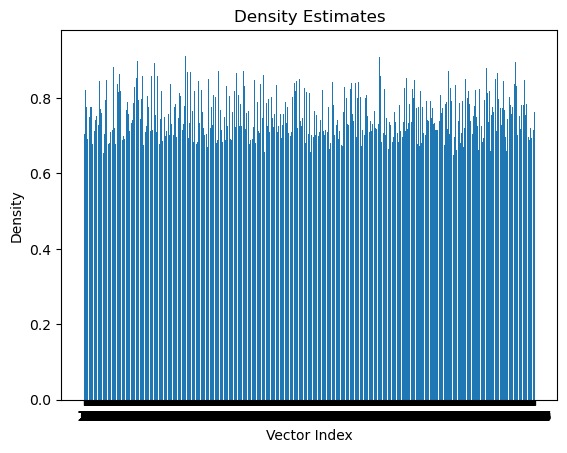

In [38]:
plot_density_estimates(sim_Y)  # Not density estimates, but confidence estimates

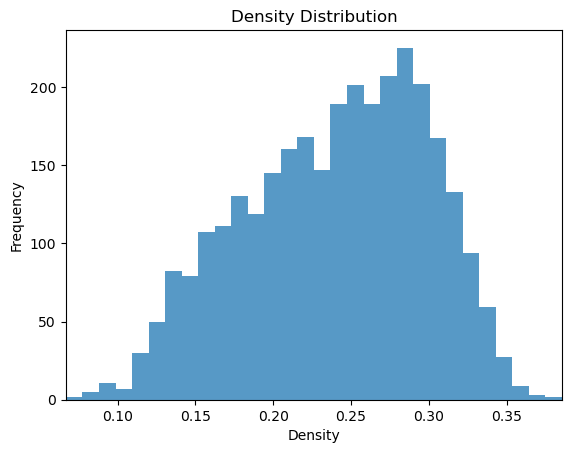

In [39]:
plot_density_distribution(1 - sim_Y, bins=30)  # Not density distribution, but confidence distribution

In [40]:
test_snap_scores = np.array(test_snap_scores)

In [ ]:
test_snap_scores = test_snap_scores[sim_X != 0]
sim_Y = sim_Y[sim_X != 0]
data = data[sim_X != 0]
sim_X = sim_X[sim_X != 0]

In [82]:
print(compute_similarity_metrics(test_snap_scores_3, consistency))
print(compute_similarity_metrics(test_snap_scores_3, sim_X))
print(compute_similarity_metrics(test_snap_scores_3, sim_Y))

{'pearson_corr': -0.2155469507294917, 'spearman_corr': -0.22917830789239627, 'mse': 2.3312289241985136, 'rmse': 1.5268362466874152, 'cosine_sim': 0.9262244645196773, 'kl_divergence': 1666.5318875516214, 'jaccard_sim': 0.0}
{'pearson_corr': 0.3549631420159478, 'spearman_corr': 0.34688906399767555, 'mse': 2.2017565801751044, 'rmse': 1.4838317223240325, 'cosine_sim': 0.9480517365315375, 'kl_divergence': 1511.281326389268, 'jaccard_sim': 0.0}
{'pearson_corr': 0.4990815353379512, 'spearman_corr': 0.46439919571580657, 'mse': 1.2851158357159194, 'rmse': 1.1336294966680778, 'cosine_sim': 0.9821547866442707, 'kl_divergence': 577.347749024674, 'jaccard_sim': 0.0}


In [45]:
import pandas as pd

data_ood = {
    "id": np.arange(len(test_spec_masses_ood[0::k])),
    "spec_mass": test_spec_masses_ood[0::k],
    "spec_charge": test_spec_charges_ood[0::k],
    "variations": traces_ood,
    "density": prob_density_specs_ood,
    "consistency": consistency_ood,
    "sim_X": sim_X_ood,
    "sim_Y": sim_Y_ood,
    "label": np.zeros(len(test_spec_masses_ood[0::k]), dtype=int),
}

data_id = {
    "id": np.arange(len(test_spec_masses_id[0::k])),
    "spec_mass": test_spec_masses_id[0::k],
    "spec_charge": test_spec_charges_id[0::k],
    "variations": traces_id,
    "density": prob_density_specs_id,
    "consistency": consistency_id,
    "sim_X": sim_X_id,
    "sim_Y": sim_Y_id,
    "label": np.ones(len(test_spec_masses_id[0::k]), dtype=int),
}

df_id = pd.DataFrame(data=data_id)
df_ood = pd.DataFrame(data=data_ood)

data_df = pd.concat([df_id, df_ood])
data_df = data_df.reset_index(drop=True)
data_df.to_csv("outputs/data_df.csv", index=False)
data_df.head()

,id,spec_mass,spec_charge,variations,density,consistency,sim_X,sim_Y,label
0,0,2000.003656,2,0.070243,384.813450,0.406232,0.249069,0.655301,1
1,1,2000.003656,2,0.070243,393.700999,0.461639,0.249069,0.710707,1
2,2,2000.003656,2,0.070243,383.168119,0.413326,0.249069,0.662395,1
3,3,2000.006213,2,0.013558,393.751275,0.219807,0.586679,0.806486,1
4,4,2000.006213,2,0.013558,395.118184,0.208016,0.586679,0.794695,1


In [45]:
df_all = pd.read_csv('outputs/df_all.csv')
df_all.head()
df_all['label'] = int(1)
df = pd.concat([df_all, df_all_ood])
df = df.reset_index(drop=True)

# drop columns snap_1, snap_2, snap_label
df = df.drop(columns=['snap_1', 'snap_2', 'snap_label'])
df.head()
df.to_csv('outputs/df_all_classify.csv', index=False)

In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_curve

# Load the data
df_all = df

# Preprocess the data
df_all = pd.get_dummies(df_all, columns=['spec_charge'])

# Define the feature columns
feature_cols = [col for col in df_all.columns if col not in ['label']]
# feature_cols = ['sim_Y']

# Define the label columns
label_cols = ['label']

# Separate the features and labels
X = df_all[feature_cols]
y = df_all[label_cols]

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X.values.reshape(-1, 1))

# Apply SMOTE for 'snap_label'
smote = SMOTE(random_state=42)
# X_res, y_res = smote.fit_resample(X, y['label'])
X_res, y_res = X, y['label']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

# Define the models and their associated hyperparameters
models = [
    {
        'name': 'RandomForestRegressor',
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [1, 10, 20, 30, 40],
            'min_samples_split': [2, 5, 10]
        }
    },
    {
        'name': 'GradientBoostingRegressor',
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2, 0.3],
            'max_depth': [3, 5, 10, 20]
        }
    },
    {
        'name': 'GradientBoostingClassifier',
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2, 0.3],
            'max_depth': [3, 5, 10, 20]
        }
    }
]

# Loop over the models
for m in models:
    print(f"Training {m['name']}...")

    # Apply GridSearchCV
    grid = GridSearchCV(m['model'], m['params'], cv=5, verbose=0, n_jobs=-1)
    grid.fit(X_train, y_train)

    # Predict on the validation set
    y_pred_proba = grid.predict(X_val)

    # Scatter plot of y_pred_proba vs snap_score_1
    # scatter_plot(y_val['snap_1'], y_pred_proba, 'snap_score_1', 'y_pred_proba', f"Plot for {m['name']}", legend=True)

    # Calculate the ROC AUC for snap_label
    roc_auc_snap_label = roc_auc_score(y_val, y_pred_proba)

    # Print the ROC AUC
    print(f"ROC AUC snap_label: {roc_auc_snap_label}")

    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

    # Find the optimal threshold
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    # Print the optimal threshold
    print(f"Optimal threshold: {optimal_threshold}")

    # Convert probabilities to binary predictions using the optimal threshold
    y_pred_snap_label = (y_pred_proba >= optimal_threshold).astype(int)

    # Print the best hyperparameters
    print(f"Best hyperparameters: {grid.best_params_}")

    # Print the classification report for snap_label
    print(classification_report(y_val, y_pred_snap_label))

    # Plot the ROC curve
    plot_roc_curve(fpr, tpr, optimal_idx)

    # Get the feature importances
    feature_importances = grid.best_estimator_.feature_importances_

    # Create a DataFrame to display the feature importances
    importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': feature_importances
    })

    # Sort the DataFrame by importance in descending order
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Print the feature importances
    print(f"Feature Importances for {m['name']}:")
    print(importance_df)
    print("\n")


ModuleNotFoundError: No module named 'imblearn'